ACCESS THE BELOW LINK TO SEE THE IMAGES PROPERLY 
https://www.kaggle.com/rocketvisnu/grad-cam-visualization-for-ds2-vgg-net 

In [1]:
!pip install torchsummary
!pip install omnixai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.9/534.9 kB 8.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 34.0 MB/s eta 0:00:00
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp37-cp37m-linux_x86_64.whl size=2247690 sha256=fb770b2b645fc40849294217c70d831ef560ef045b8ec69203bc5413bc32437f
  Stored in directory: /root/.cache/pip/wheels/66/8b/20/94d912531a679a865ad5517c7f341b7cbef77b1203ef22383e
Successfully built hnswlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil

import json
from PIL import Image as PilImage

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM

import warnings
warnings.filterwarnings("ignore")

In [3]:
BATCH_SIZE = 128
LR = 0.0001

In [4]:
# Define the preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
])

In [5]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Training Data', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Testing Data', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Validation Data', transform=transform)

In [6]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']
10


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=False).features
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

In [10]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
model = VGG16(num_classes = len(class_names)).to(device)

In [13]:
best_checkpoint = torch.load('/kaggle/input/d2-vgg16-model/d2_vgg16_model_checkpoint.pth')
print(best_checkpoint.keys())
model.load_state_dict(best_checkpoint['state_dict'])
# load the saved weights from a .pth file

# set the model to evaluation mode
model.eval()

dict_keys(['epoch', 'state_dict', 'optimizer', 'train_loss', 'val_loss'])


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [14]:
img_path = '/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Testing Data/Aster/Aster-Test (105).jpeg'


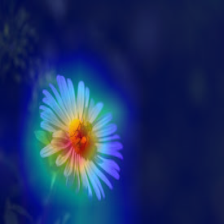
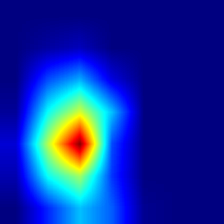

In [15]:
img = Image(PilImage.open(img_path).convert('RGB'))
explainer = GradCAM(
    model=model,
    target_layer = model.features[-1],
    preprocess_function=preprocess
)
explanations = explainer.explain(img)
explanations.ipython_plot(index=0, class_names=class_names)


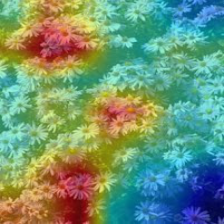
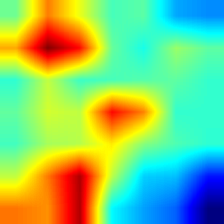


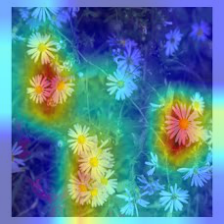
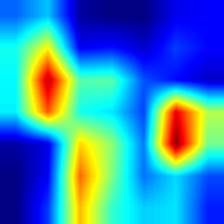


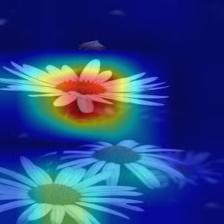
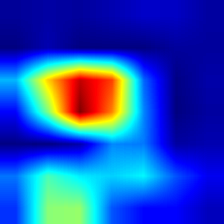


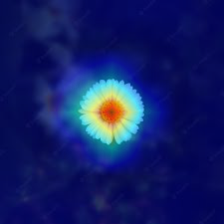
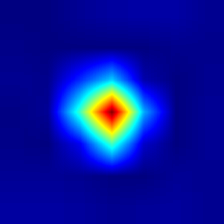


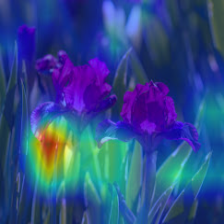
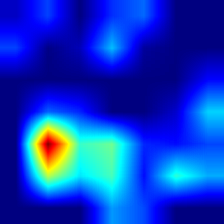


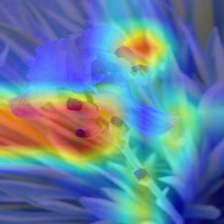
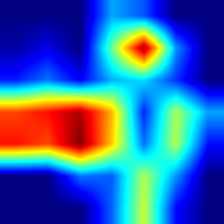


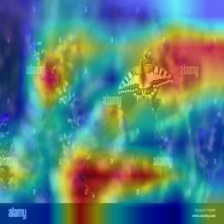
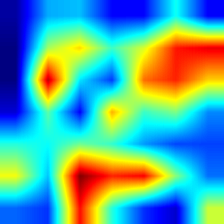


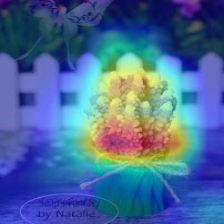
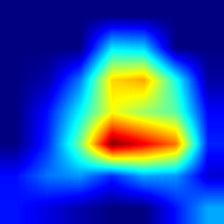


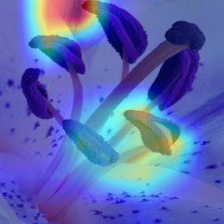
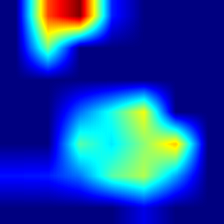


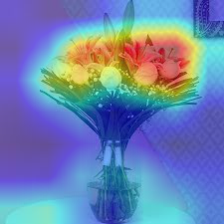
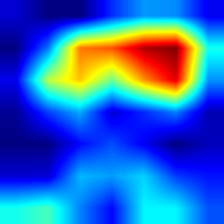


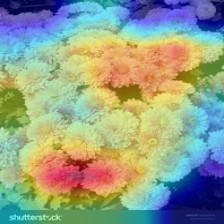
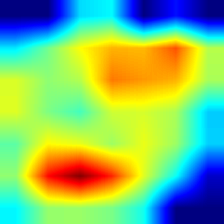


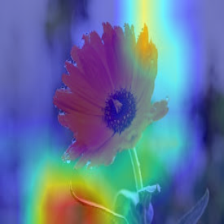
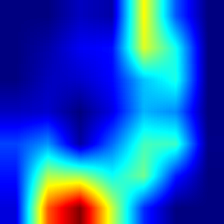


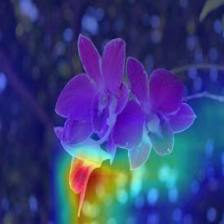
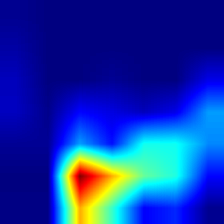


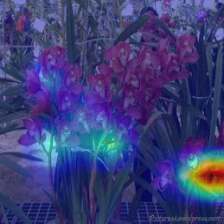
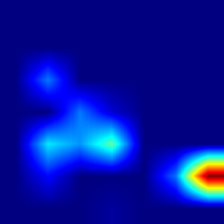


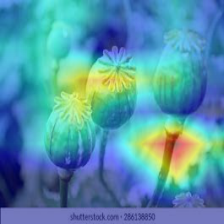
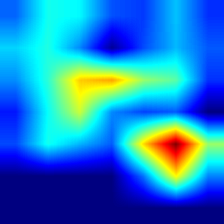


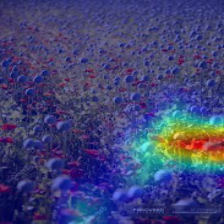
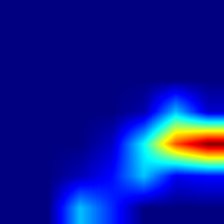


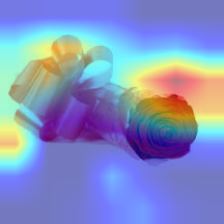
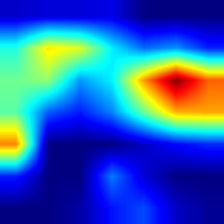


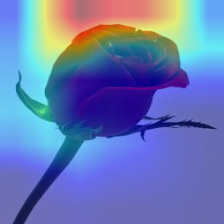
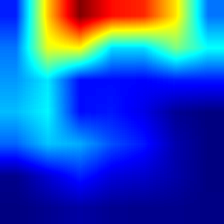


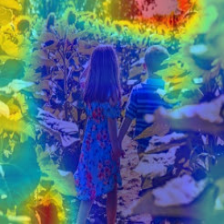
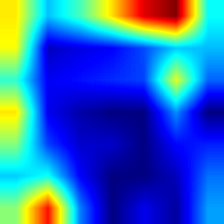


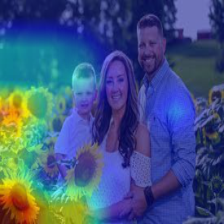
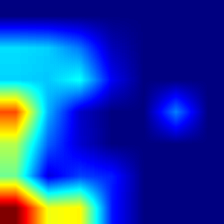

In [20]:
import os
import matplotlib.pyplot as plt
import numpy as np

test_dir = '/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Training Data/'

classes = ['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']

num_images = 2

for i, cls in enumerate(classes):
    cls_dir = os.path.join(test_dir, cls)
    
    img_files = os.listdir(cls_dir)
    
    img_files = np.random.choice(img_files, size=num_images, replace=False)
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(cls_dir, img_file)
        
        img = Image(PilImage.open(img_path).convert('RGB'))

        explainer = GradCAM(
            model=model,
            target_layer = model.features[-1],
            preprocess_function=preprocess
        )
        explanations = explainer.explain(img)
        explanations.ipython_plot(index=0, class_names=class_names)
